## Split Dataset into Training, Validation, and Test Sets

In [9]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = r"D:\ML A-Z\ByteWise Fellowship\Final Project\Dataset"
train_path = 'Dataset/train'
validation_path = 'Dataset/validation'
test_path = 'Dataset/test'

# Create directories
for path in [train_path, validation_path, test_path]:
    for class_name in ['Diabetic_Maculr', 'Macular_Edema', 'normal']:
        os.makedirs(os.path.join(path, class_name), exist_ok=True)

# Function to split data
def split_data(class_path, train_ratio=0.7, validation_ratio=0.2):
    files = os.listdir(class_path)
    train_files, test_files = train_test_split(files, test_size=1-train_ratio, random_state=42)
    validation_files, test_files = train_test_split(test_files, test_size=validation_ratio/(1-train_ratio), random_state=42)

    for file_name in train_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(train_path, class_name, file_name))
    for file_name in validation_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(validation_path, class_name, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(test_path, class_name, file_name))

# Split each class directory
for class_name in ['Diabetic_Maculr', 'Macular_Edema', 'normal']:
    class_path = os.path.join(dataset_path, class_name)
    split_data(class_path)

# Importing  Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Load and Preprocess Data

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 837 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


## Build the CNN Model

In [28]:
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes
])

## Compile the Model

In [31]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Model

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/25
26/26 [==============================] - 103s 4s/step - loss: 1.0892 - accuracy: 0.3677 - val_loss: 1.0901 - val_accuracy: 0.4167
Epoch 2/25
26/26 [==============================] - 99s 4s/step - loss: 1.0635 - accuracy: 0.4137 - val_loss: 1.2541 - val_accuracy: 0.3542
Epoch 3/25
26/26 [==============================] - 100s 4s/step - loss: 0.9970 - accuracy: 0.4745 - val_loss: 1.0794 - val_accuracy: 0.4479
Epoch 4/25
26/26 [==============================] - 106s 4s/step - loss: 0.9812 - accuracy: 0.4845 - val_loss: 1.1965 - val_accuracy: 0.4271
Epoch 5/25
26/26 [==============================] - 106s 4s/step - loss: 0.9879 - accuracy: 0.4646 - val_loss: 1.0289 - val_accuracy: 0.4583
Epoch 6/25
26/26 [==============================] - 109s 4s/step - loss: 0.9495 - accuracy: 0.5043 - val_loss: 1.1059 - val_accuracy: 0.4167
Epoch 7/25
26/26 [==============================] - 102s 4s/step - loss: 0.9617 - accuracy: 0.4733 - val_loss: 1.2039 - val_accuracy: 0.3854
Epoch 8/25
26/

## Evaluate and Visualize the Results

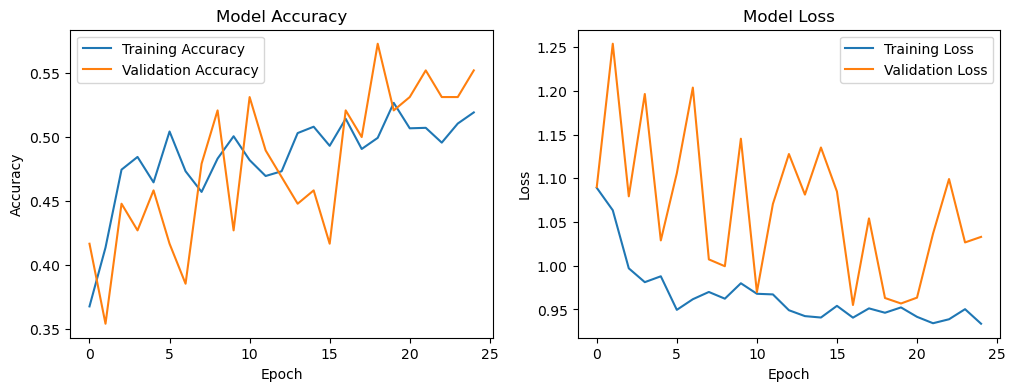

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Save the Model

In [34]:
model.save('retinal_vessel_classifier.h5')

## Set Up Transfer Learning with ResNet50

In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

## Compile the Model

In [39]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Model

In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/25
26/26 [==============================] - 78s 3s/step - loss: 3.9717 - accuracy: 0.3689 - val_loss: 1.5257 - val_accuracy: 0.3542
Epoch 2/25
26/26 [==============================] - 69s 3s/step - loss: 1.1644 - accuracy: 0.4186 - val_loss: 1.1207 - val_accuracy: 0.4062
Epoch 3/25
26/26 [==============================] - 70s 3s/step - loss: 1.0284 - accuracy: 0.4634 - val_loss: 1.1186 - val_accuracy: 0.3958
Epoch 4/25
26/26 [==============================] - 80s 3s/step - loss: 1.0528 - accuracy: 0.4398 - val_loss: 1.0831 - val_accuracy: 0.3646
Epoch 5/25
26/26 [==============================] - 79s 3s/step - loss: 1.0298 - accuracy: 0.4298 - val_loss: 1.0921 - val_accuracy: 0.3542
Epoch 6/25
26/26 [==============================] - 80s 3s/step - loss: 1.0181 - accuracy: 0.4460 - val_loss: 1.2332 - val_accuracy: 0.3646
Epoch 7/25
26/26 [==============================] - 78s 3s/step - loss: 1.0373 - accuracy: 0.4509 - val_loss: 1.1071 - val_accuracy: 0.3854
Epoch 8/25
26/26 [==

## Evaluate and Visualize the Results

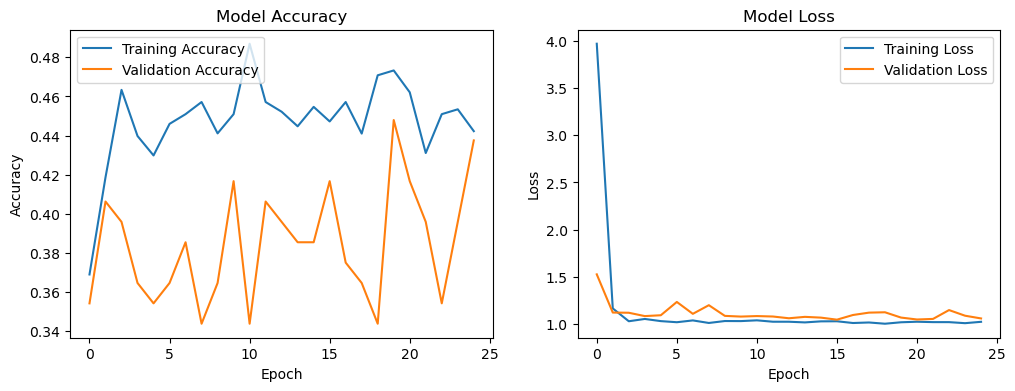

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save the Model

In [42]:
model.save('retinal_vessel_classifier_resnet50.h5')